# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

In [25]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

df = pd.read_csv("AB_NYC_2019.csv")
df.head()

Saving AB_NYC_2019.csv to AB_NYC_2019 (3).csv


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [27]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [28]:
# Проверка пропущенных значений
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percentage
name,16,0.032723
host_name,21,0.042949
last_review,10052,20.558339
reviews_per_month,10052,20.558339


In [29]:
# Удаляем неинформативные признаки
df.drop(["id", "name", "host_id", "host_name", "last_review"], axis=1, inplace=True)

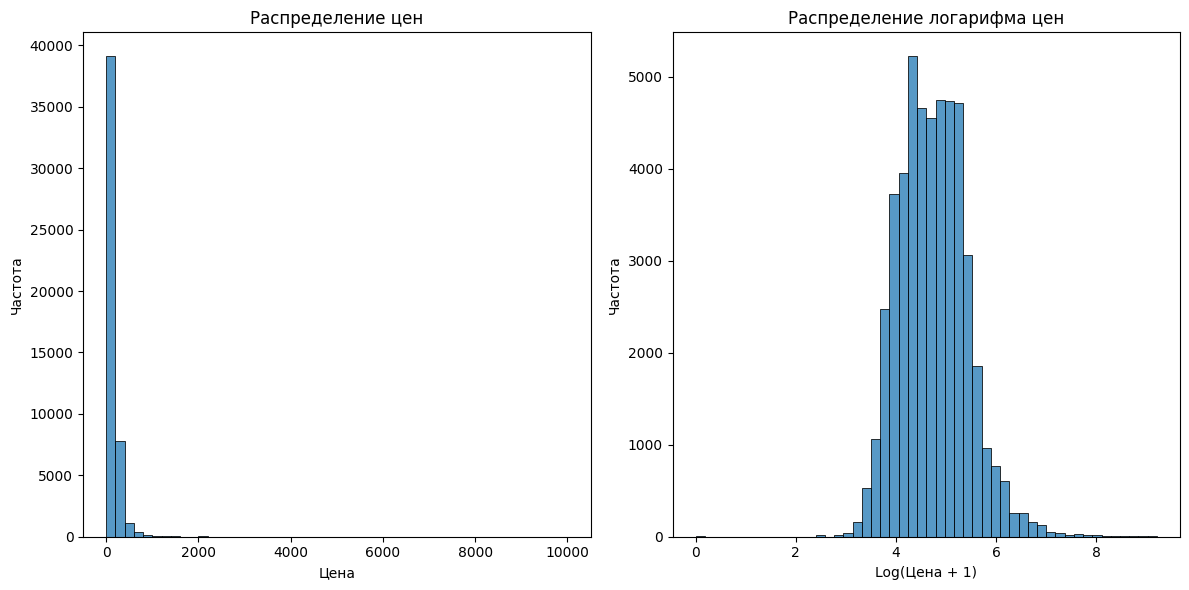

In [33]:
# Распределение целевой переменной (price)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50)
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['price']), bins=50)
plt.title('Распределение логарифма цен')
plt.xlabel('Log(Цена + 1)')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

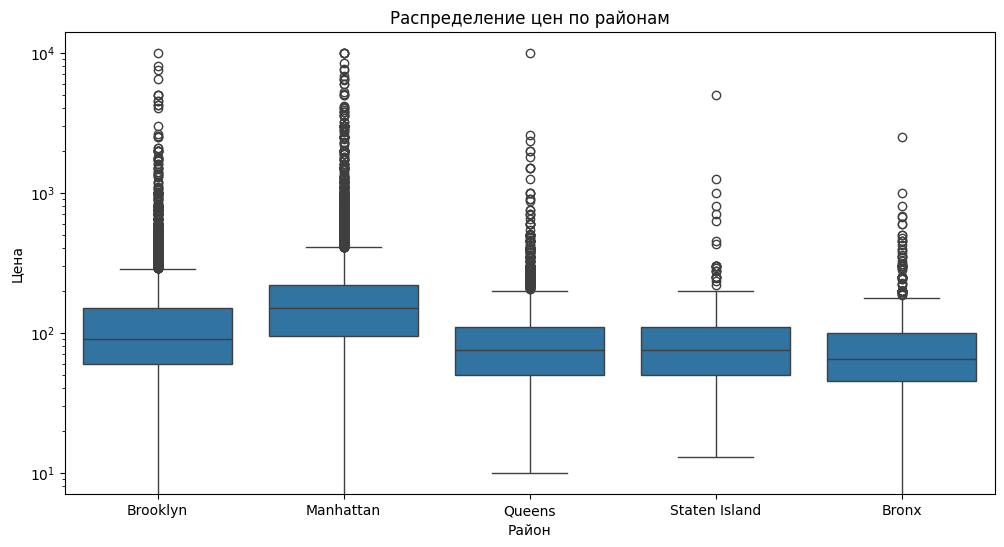

In [35]:
# Распределение цен по районам (neighbourhood_group)
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title('Распределение цен по районам')
plt.xlabel('Район')
plt.ylabel('Цена')
plt.yscale('log')
plt.show()

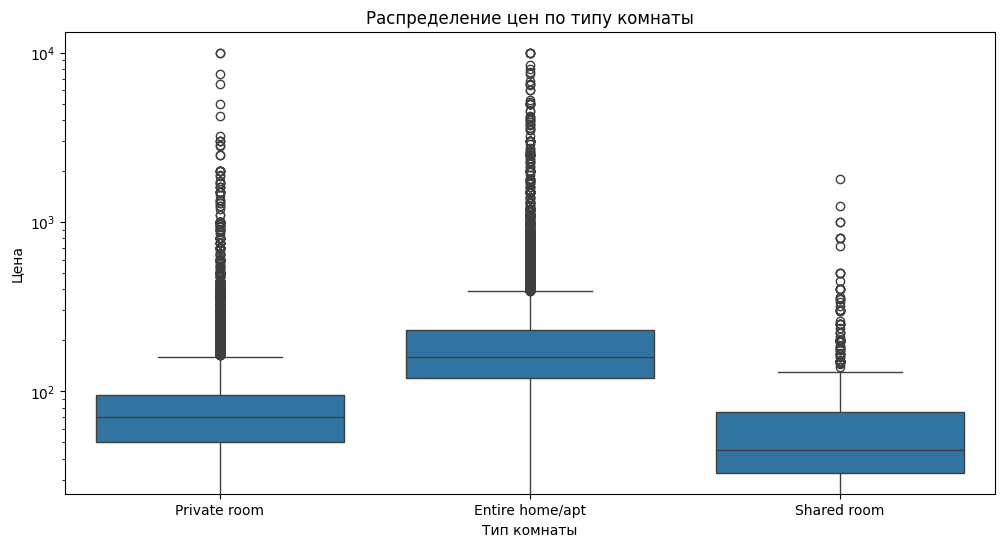

In [37]:
# Распределение цен по типу комнаты (room_type)
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Распределение цен по типу комнаты')
plt.xlabel('Тип комнаты')
plt.ylabel('Цена')
plt.yscale('log')
plt.show()

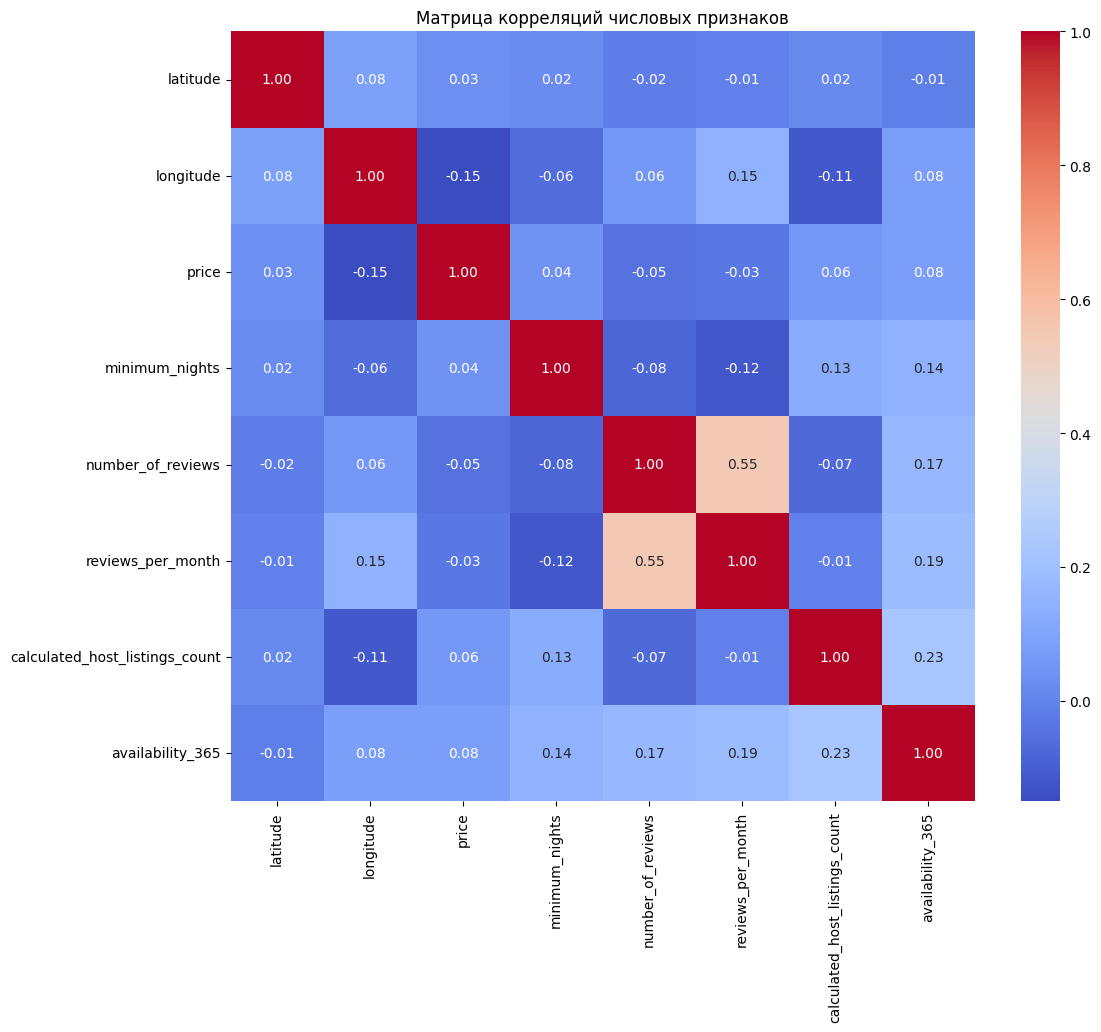

In [39]:
# Матрица корреляций для числовых признаков
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций числовых признаков')
plt.show()

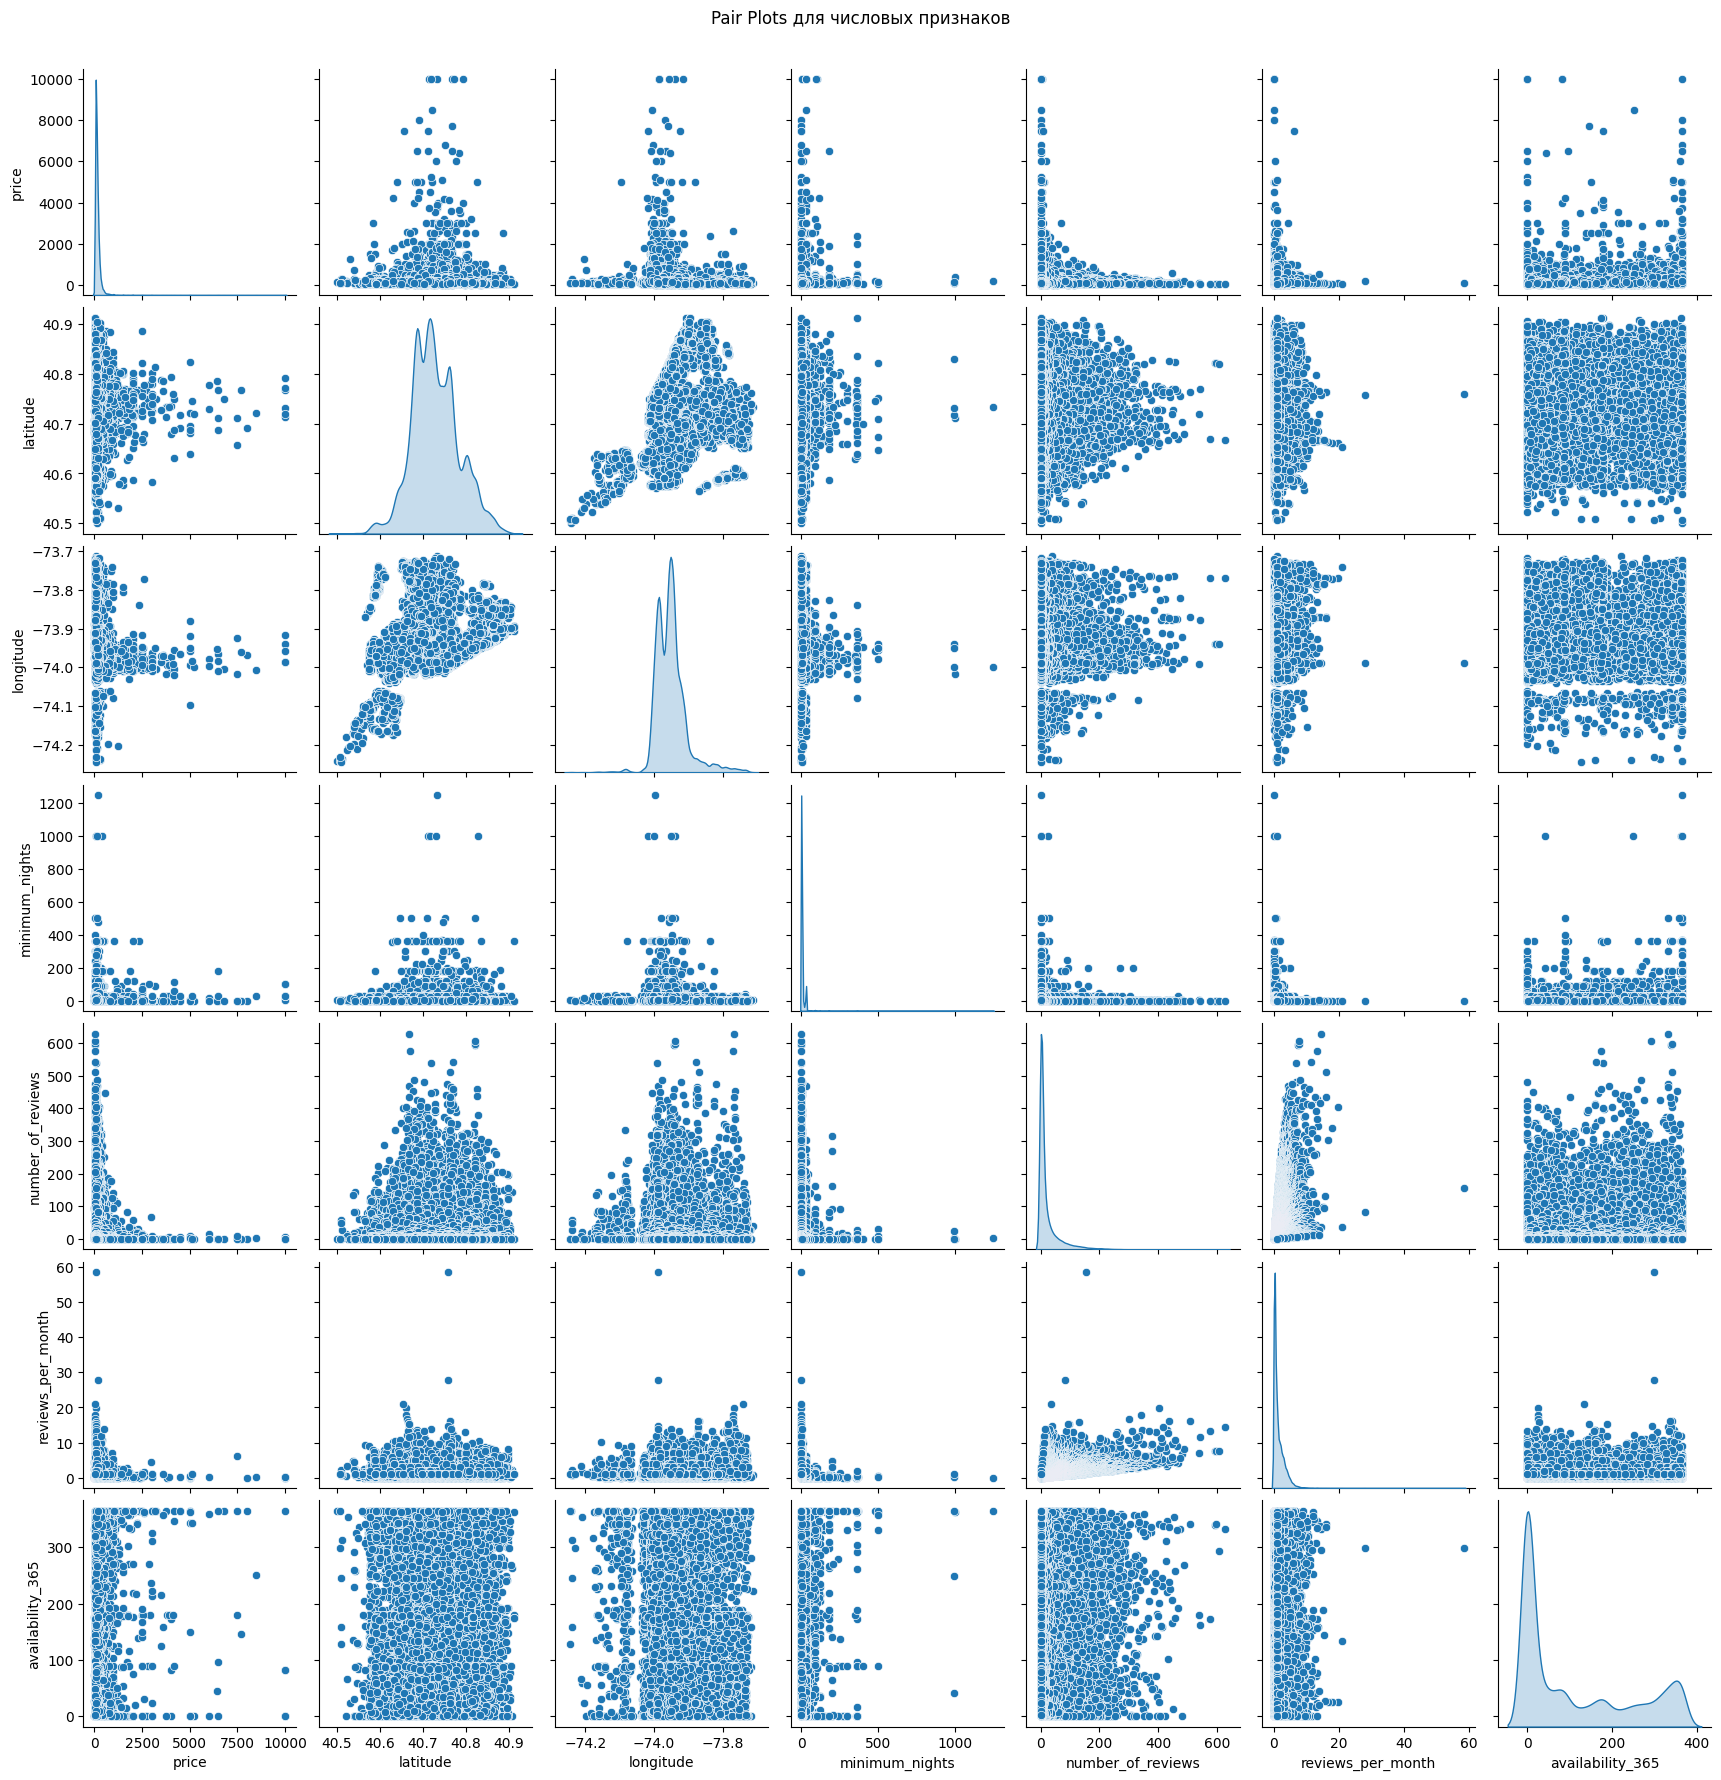

In [41]:
# Pair plots для некоторых числовых признаков
selected_numeric_cols = ['price', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
sns.pairplot(df[selected_numeric_cols], diag_kind='kde')
plt.suptitle('Pair Plots для числовых признаков', y=1.02)
plt.show()

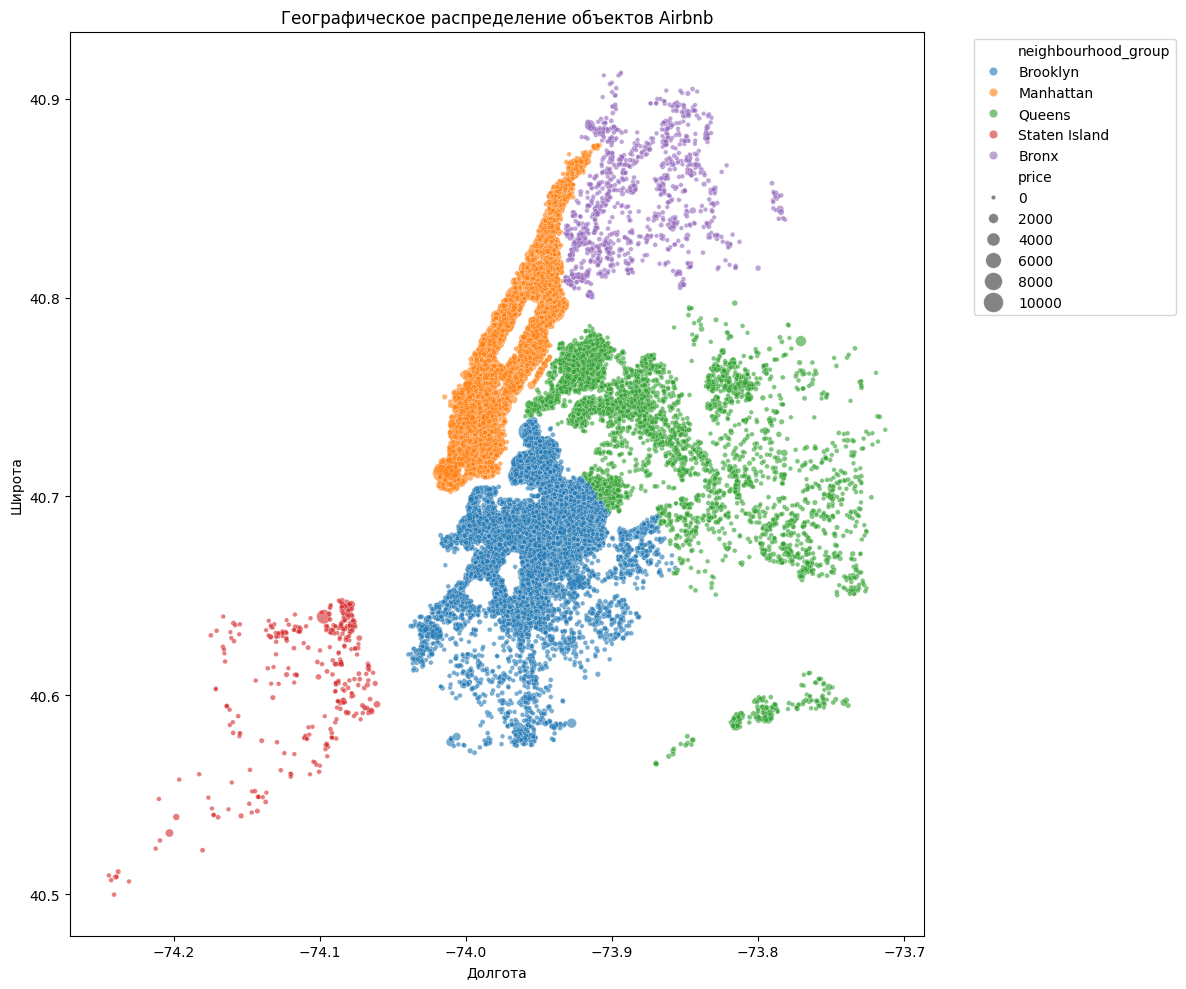

In [43]:
# Визуализация географического распределения объектов
plt.figure(figsize=(12, 10))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group',
                size='price', sizes=(10, 200), alpha=0.6, data=df)
plt.title('Географическое распределение объектов Airbnb')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Часть 2: Preprocessing & Feature Engineering

In [44]:
# Создаем копию данных для предобработки
df_copy = df.copy()

In [45]:
# Обработка выбросов в цене
# Ограничим цену 99-м перцентилем, так как есть очень дорогие объекты
price_99_percentile = df_copy['price'].quantile(0.99)
print(f"99-й перцентиль цены: ${price_99_percentile:.2f}")

df_filtered = df_copy[df_copy['price'] <= price_99_percentile].copy()
print(f"Размер отфильтрованного датасета: {df_filtered.shape}")
print(f"Удалено {df_copy.shape[0] - df_filtered.shape[0]} строк с экстремальными ценами")

99-й перцентиль цены: $799.00
Размер отфильтрованного датасета: (48421, 11)
Удалено 474 строк с экстремальными ценами


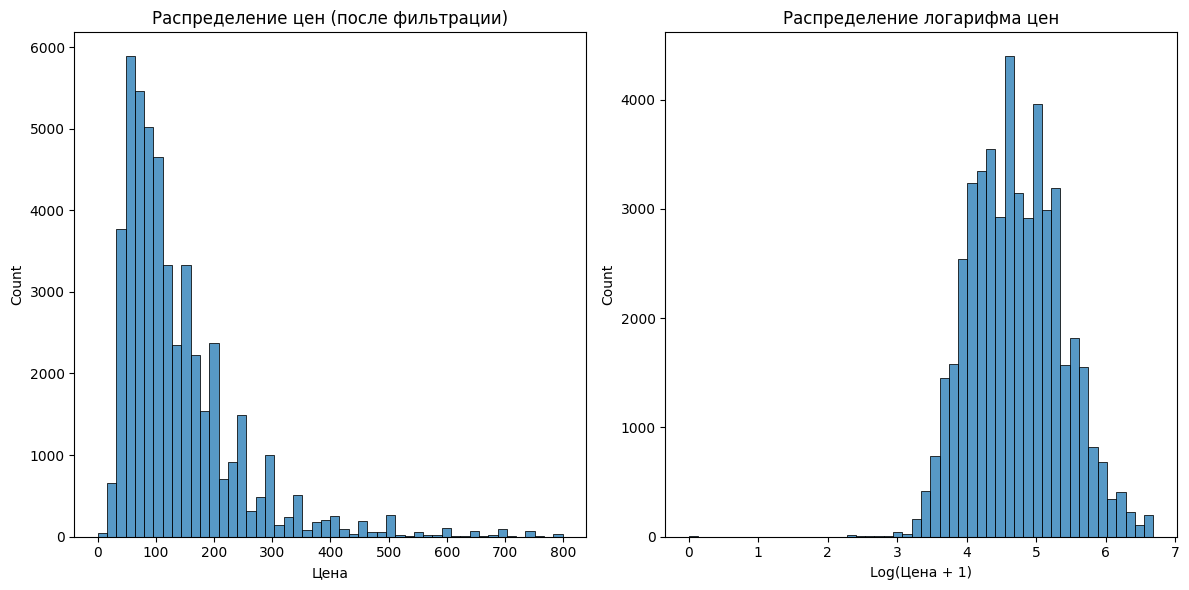

In [46]:
# Логарифмирование целевой переменной
df_filtered['log_price'] = np.log1p(df_filtered['price'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['price'], bins=50)
plt.title('Распределение цен (после фильтрации)')
plt.xlabel('Цена')

plt.subplot(1, 2, 2)
sns.histplot(df_filtered['log_price'], bins=50)
plt.title('Распределение логарифма цен')
plt.xlabel('Log(Цена + 1)')

plt.tight_layout()
plt.show()

In [48]:
import warnings
warnings.filterwarnings("ignore")
# Обработка пропущенных значений
# Заполним пропущенные значения в reviews_per_month нулями
df_filtered['reviews_per_month'].fillna(0, inplace=True)

In [49]:
# Создание новых признаков

# 1. Расстояние до центра Манхэттена (Times Square)
# Координаты Times Square: 40.7580° N, 73.9855° W
times_square_lat = 40.7580
times_square_lon = -73.9855

# Функция для расчета евклидова расстояния
def calculate_distance(lat, lon, center_lat, center_lon):
    return np.sqrt((lat - center_lat)**2 + (lon - center_lon)**2)

df_filtered['distance_to_times_square'] = df_filtered.apply(
    lambda row: calculate_distance(row['latitude'], row['longitude'], times_square_lat, times_square_lon),
    axis=1
)

# 2. Создадим признак, показывающий, является ли объект "Entire home/apt"
df_filtered['is_entire_home'] = (df_filtered['room_type'] == 'Entire home/apt').astype(int)

# 3. Создадим признак, показывающий, находится ли объект в Манхэттене
df_filtered['is_manhattan'] = (df_filtered['neighbourhood_group'] == 'Manhattan').astype(int)

# 4. Создадим признак, показывающий соотношение отзывов к минимальному количеству ночей
df_filtered['reviews_per_min_nights'] = df_filtered['number_of_reviews'] / df_filtered['minimum_nights'].replace(0, 1)

# 5. Создадим признак, показывающий процент доступности в году
df_filtered['availability_ratio'] = df_filtered['availability_365'] / 365

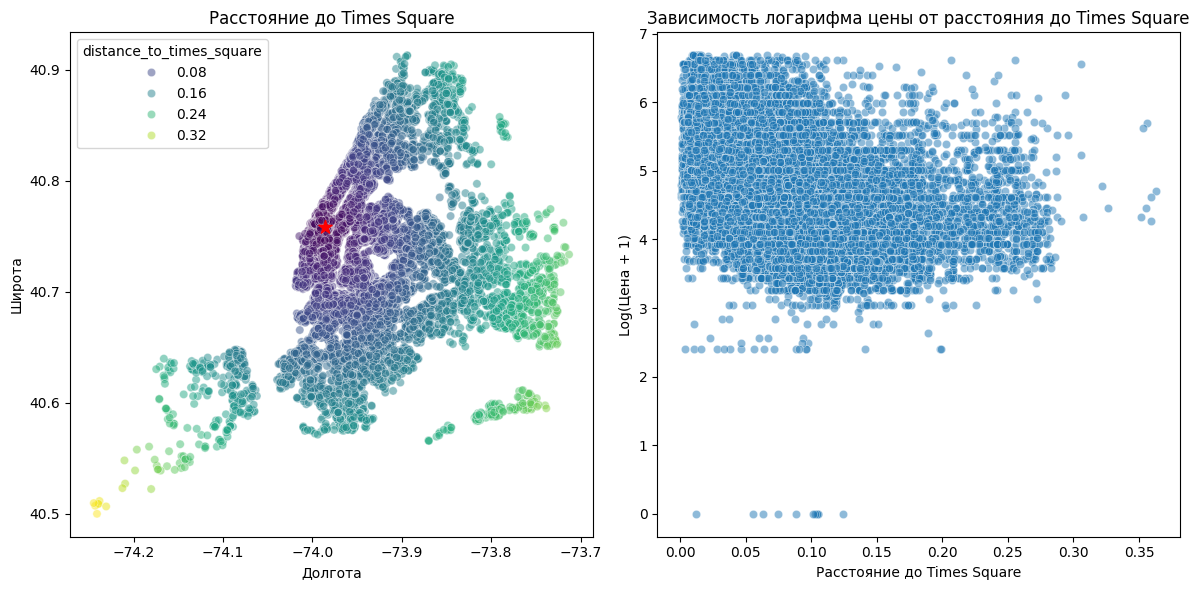

In [50]:
# Визуализация нового признака - расстояние до Times Square
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='longitude', y='latitude', hue='distance_to_times_square',
                palette='viridis', data=df_filtered, alpha=0.5)
plt.scatter(times_square_lon, times_square_lat, color='red', s=100, marker='*')
plt.title('Расстояние до Times Square')
plt.xlabel('Долгота')
plt.ylabel('Широта')

plt.subplot(1, 2, 2)
sns.scatterplot(x='distance_to_times_square', y='log_price', data=df_filtered, alpha=0.5)
plt.title('Зависимость логарифма цены от расстояния до Times Square')
plt.xlabel('Расстояние до Times Square')
plt.ylabel('Log(Цена + 1)')

plt.tight_layout()
plt.show()

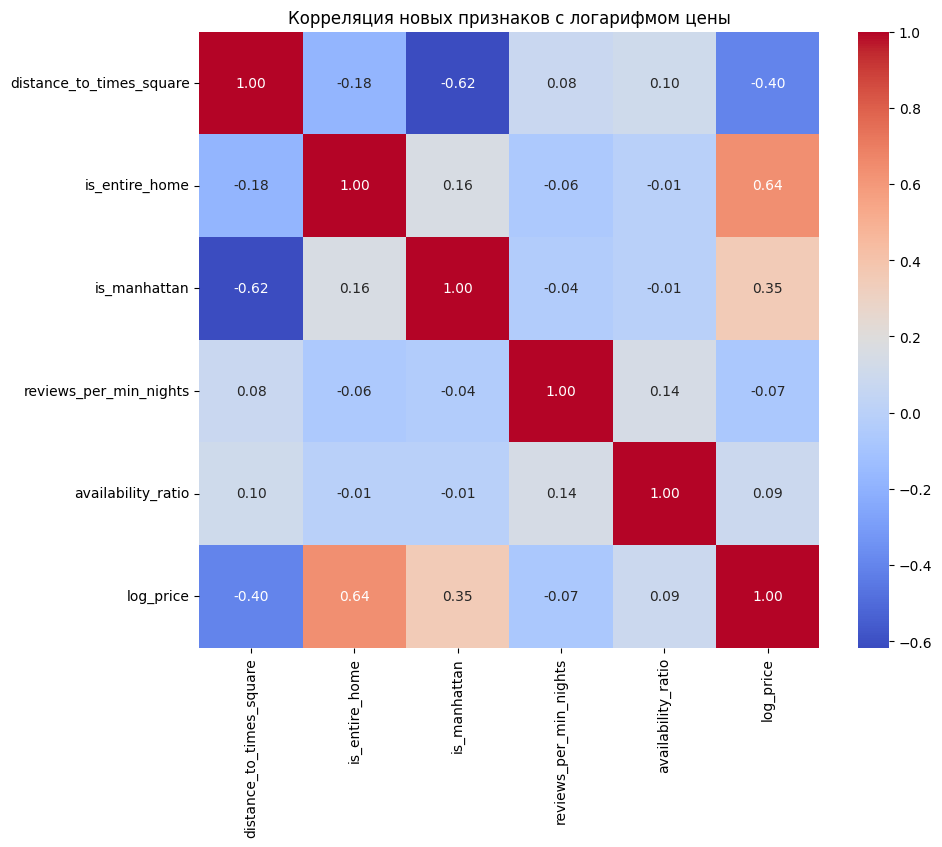

In [51]:
# Проверим корреляцию новых признаков с целевой переменной
new_features = ['distance_to_times_square', 'is_entire_home', 'is_manhattan',
                'reviews_per_min_nights', 'availability_ratio', 'log_price']
corr_new_features = df_filtered[new_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_new_features, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция новых признаков с логарифмом цены')
plt.show()

In [52]:
# Подготовка данных для моделирования

# Определим категориальные и числовые признаки
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']
numerical_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                      'reviews_per_month', 'calculated_host_listings_count', 'availability_365',
                      'distance_to_times_square', 'reviews_per_min_nights', 'availability_ratio']

# Создадим бинарные признаки
binary_features = ['is_entire_home', 'is_manhattan']

# Определим X и y
X = df_filtered[categorical_features + numerical_features + binary_features]
y = df_filtered['log_price']  # Используем логарифм цены как целевую переменную

# Разделим данные на обучающую и тестовую выборки (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
# Создадим препроцессор для категориальных и числовых признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # Используем RobustScaler для устойчивости к выбросам
])

# Объединим трансформеры в один препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Оставляем бинарные признаки без изменений
)

## Часть 3: Моделирование

In [55]:
# Функция для оценки качества модели
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказания на обучающей и тестовой выборках
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Расчет метрик качества
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Преобразование метрик MAE и RMSE обратно в исходную шкалу цен
    train_mae_original = np.expm1(train_mae)
    test_mae_original = np.expm1(test_mae)

    train_rmse_original = np.expm1(train_rmse)
    test_rmse_original = np.expm1(test_rmse)

    # Вывод результатов
    print(f"Модель: {model_name}")
    print(f"R² на обучающей выборке: {train_r2:.4f}")
    print(f"R² на тестовой выборке: {test_r2:.4f}")
    print(f"MAE на обучающей выборке (log): {train_mae:.4f}, (original): ${train_mae_original:.2f}")
    print(f"MAE на тестовой выборке (log): {test_mae:.4f}, (original): ${test_mae_original:.2f}")
    print(f"RMSE на обучающей выборке (log): {train_rmse:.4f}, (original): ${train_rmse_original:.2f}")
    print(f"RMSE на тестовой выборке (log): {test_rmse:.4f}, (original): ${test_rmse_original:.2f}")
    print("-" * 80)

    return {
        'model': model,
        'model_name': model_name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }

In [54]:
# Создадим и обучим модели

# 1. Линейная регрессия
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 2. Ridge регрессия с кросс-валидацией
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5))
])

# 3. Lasso регрессия с кросс-валидацией
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, max_iter=10000))
])

# 4. ElasticNet регрессия с кросс-валидацией
elasticnet_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0],
                              l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
                              cv=5, max_iter=10000))
])